-----------

# TRABAJO PRACTICO FINAL

### DIGITAL HOUSE: Data Science
### Junio 2022

<br>

## GRUPO 1
- Integrantes:
    - Gonzalo Barbot - PM: Project Manager
    - Agustin Stigliano - CDM: Code Development Manager
    - Fernando Dupont - PDM: Presentation Development Manager
    
<br>

## TEMA: Pronósticos sobre Series Temporales
<br>

-----

# NOTEBOOK MACHINE LEARNING:


### IMPORTACION DE LIBRERIAS

Activación de logging

In [1]:
import SmartSeries
import APP_REG_LOG_EST as reg
import APP_ARIMA as arima
import APP_XGBOOST as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import pickle

import logging
import datetime as dt
formatter = '%(levelname)s:\n %(message)s | %(asctime)s\n'#| line %(lineno)d\n'
logging.basicConfig(filename='logfile_Machine_learning.log', level=logging.INFO, force=True, filemode='w', **{'format':formatter})
logger = logging.getLogger()

xgboost version actual: 1.5.0
Version de diseño en 14/6/2022
	xgboost version: 1.6.0


In [2]:
import SmartPandas
from SmartPandas import x_en
def x():
    return x_en('log_ML')

def show_df(df):
    display (df)
    print (df.index)
    display (SmartPandas.data_info(df))

In [3]:
log_message  = '{}) STARTING PROGRAM'
logger.info(log_message.format(x()))

### CARGA DEL DATASET: TIME SERIE

In [4]:
file_name = 'df_targets.csv'

df = SmartSeries.load_dataset(file_name, freq='D', dropnan=False, fillnan=True)

log_message = '{}) LOADING FUNCTION: load_dataset(): se carga el dataset llamado "{}"'
logger.info(log_message.format(x(), file_name))


Serie de tiempo: date

Cantidad de NaNs en: 
Grocery             0
Pharmaceutical      0
Natural Products    0
Bakery              1
Meat                1
NaNs imputados: método "backfill"


In [5]:
# lo que hacemos todos siempre: Chequear 2 veces las cosas
df.isna().sum()

Grocery             0
Pharmaceutical      0
Natural Products    0
Bakery              0
Meat                0
dtype: int64

### CREACION DE LAS MATRICES TARGETS

<b>SmartSeries

In [6]:
labels_category = df.columns.values

vector = SmartSeries.VectorBuilder(df)
vectores = {}
for elemento in labels_category:
    vector.create(elemento)
    vector.treatment()
    vector.dummy('W')
    vectores[elemento] = vector.vector


Serie de tiempo: date



In [7]:
# interactive display
vector.targets
vectores.keys()
vectores['Pharmaceutical'];# vectores['Pharmaceutical'].index

# MODELO 1: reg_log_est

**MODELO DE REGRESION LINEAL CON TRANSFORMACIÓN LOGARÍTMICA Y ESTACIONALIDAD**

**division de los sets**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [8]:
def check_optimized_model(results):
    return results.loc[results.RMSE.astype('float64').idxmin()].to_frame().T

def get_optimized_model(modelos, scores):
    return modelos[pd.Series(scores).idxmin()]

<b>train_test_split

entrenamiento de 6 modelos por categoria, quedandose con el mejor de cada modelos. Es verdad lo que dice gonza, que si dos categorias tienen diferente modelo tiene que estar rotulado junto con la instancia

In [9]:
log_message = '{}) Aca se debe armar un pd.DataFrame vacio para almacenar uno de cada categoria'
logger.critical(log_message.format(x()))

muestra = vectores['Meat']
modelos = reg.available_models()
nombre_modelos = reg.def_models()

#train test split: 60 dias = 2 meses
df_train, df_test = train_test_split(muestra, shuffle=False, test_size=60)

# iteracion para instanciar el modelo de statsmodels
for i in range(len(modelos)):
    modelos[i] = modelos[i](muestra, vector)

# iteracion para entrenar los modelos instanciados, y almancenar el score de las predicciones
scores = []
for i in range(len(modelos)):
    modelos[i] = modelos[i].fit()
    y_pred = modelos[i].predict(df_test)
    if i <= 3: y_pred = np.exp(y_pred) # los primeros 4 modelos predicen sobre el logartimo del target
    scores.append(np.sqrt(mean_squared_error(df_test[vector.target], y_pred)))

#resultados = {}
results = pd.DataFrame([nombre_modelos, scores]).T
log_message = '{}) ALTERATION OF VARIABLE TYPE: Cuando creo un dataset a partir de un conjunto de listas, los valores float me los convierte en series tipo "Object"'
logger.warning(log_message.format(x()))
results.columns = ['Modelo', 'RMSE']

log_message = '{}) implementando la funcion "check_optimized_model" tiene hardseteado la label "RMSE", definida previamente en la linea superior a esta'
# aca vamos a usar un dataset aparte, usando "nombre_modelos"
optimized_model = modelos[pd.Series(scores).idxmin()]
optimized_model_v2 = get_optimized_model(modelos, scores)

In [10]:
check_optimized_model(results)

,Modelo,RMSE
3,log_trend_sq,70.2222


## ESTUDIO DE SERIES ESTACIONARIAS, PRUEBA DE HIPOTESIS SOBRE LOS RESIDUOS Y SOBRE PROCESO DE DIFERENCIACION ESTANDAR

- primero:
    - X! aplicar estudio utilizando como variable: log_target - arriesgamos a que arima eliga el proceso de diferenciacion con d = 1
    - aplicar estudio utilizando como variable el resultado de algun proceso de diferenciacion

<br>

- segundo:
    - aplicar estudio utilizando como variable: diferenciacion_1 - es el residuo entre el modelo el valor real de test y el predicho por reg_log_est
    - aplicar estudio utilizando como variable: diferenciacion_2 - el resultado de get_stationarity() es la optimizacion del mejor de 3 procesos de diferenciacion (SMA, EMA, shift())

In [11]:
SmartSeries.apply_dark_mode()

In [12]:
# estudio sobre la muestra target: no hay autocorrelacion - podriamos probar p, d, q = 1, 0, 1 - cuando este listo forecast view
#arima.params_set_plot(muestra['log_Meat'])

c:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


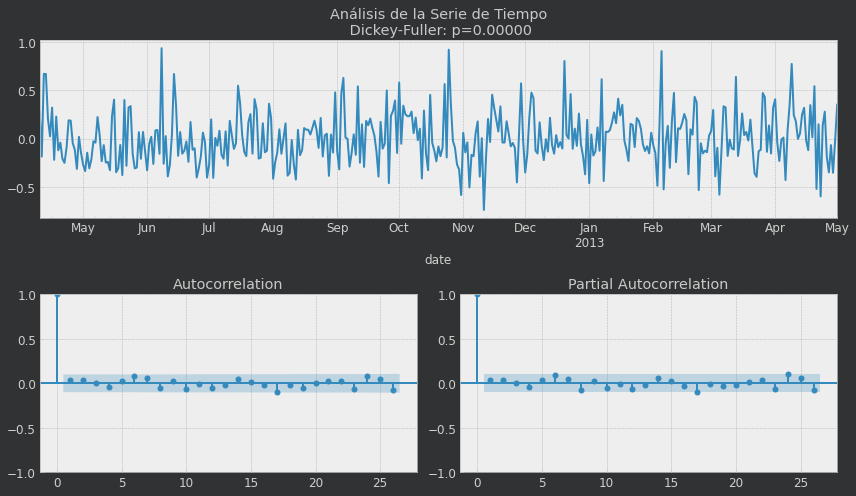

In [13]:
# proceso de diferenciacion 1: residuos entre target real y prediccion reg_log_est
y_test = df_train['log_Meat'] 
y_real = df_train['Meat']

y_pred = optimized_model.predict(df_train)

residuo = y_test - y_pred

arima.params_set_plot(residuo)

In [14]:
# from statsmodels.tsa.arima.model import ARIMA# hasta ahora no encontramos contexto para aplicar ARIMA

### PROCESOS DE DIFERENCIACION STANDARD

Desarrollamos 3 procesos de diferenciacion, primero y para todos, aplicamos transformacion logaritmica sobre la variable target.

El primer proceso es: log - SMA(12)

El segundo proceso es: log - EMA(12)

el tercer proceso es: log - log.shift()

<br>

Una vez obtenidos los valores del test de Dick-Fuller sobre los 3 procesos seleccionamos el que devuelva un p-value menor.

Así procedemos a optimizar el proceso de diferenciacion resultante (Solo para el primer y segundo proceso).

Se crea una iteración entre distintos valores de medias moviles y se elije la cantidad de pasos backward que devuelven la mejor curva respecto a una respuesta estacionaria.

	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 9



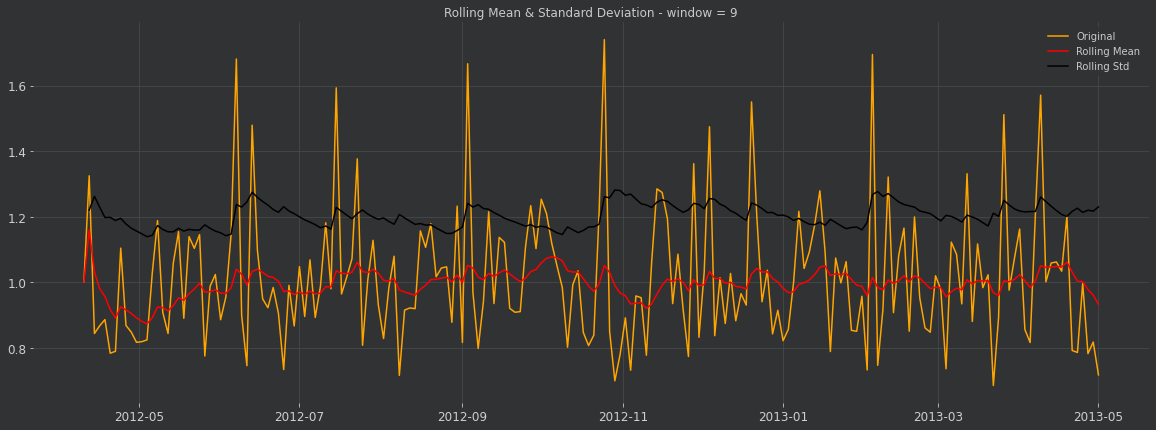

	DICK-FULLER TEST
ADF Statistic: -13.494568376174467
p-value: 3.059653709007877e-25
Critical Values:
	1%: -3.4646940755442612
	5%: -2.8766348847254934
	10%: -2.5748163958763994


In [15]:
diferenciacion = arima.test_stationarity(df_train['Meat'].resample('2d').sum())

c:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


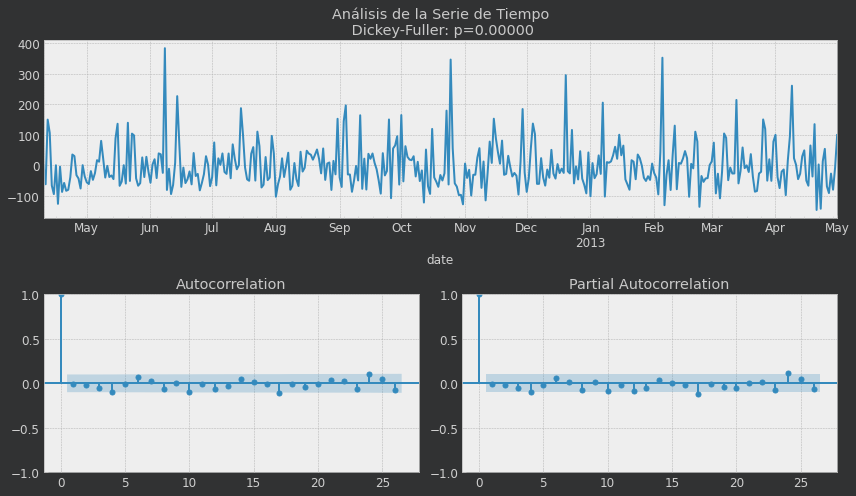

count    387.000000
mean      -1.230336
std       76.499301
min     -146.518912
25%      -50.131053
50%      -19.159373
75%       33.448294
max      383.723931
Name: Meat, dtype: float64

In [16]:
EMA_9 = df_train['Meat'].ewm(9).mean()
diferenciacion_2 = df_train['Meat'] - EMA_9
arima.params_set_plot(diferenciacion_2)
diferenciacion_2.describe()

**MODELO XGBOOST**

In [17]:
error, df_test_xgboost, df_pred_xgboost = xgb.walk_forward_validation(muestra['Meat'].to_frame(), n_test=60)

100%|██████████| 60/60 [00:23<00:00,  2.54it/s]


In [18]:
line = 'xgboost RMSE prediction = {}'
print (line.format(np.sqrt(error)))

117.02762363701997

In [20]:
xgboost_optimize = False
if xgboost_optimize:
    xgboost_scores = {}
    xgboost_predictions = {}
    logger.critical('{}) V2: En vez de diccionarios vacíos hay que implementar DataFrame vacios'.format(x()))
    for i, elemento in enumerate(range(25,76,5)):
        error, df_test_xgboost, df_pred_xgboost = xgb.walk_forward_validation(muestra['Meat'].to_frame(), n_test=elemento)
        xgboost_scores['RMSE'] = {f'{elemento}_steps': [np.sqrt(error)]}
        xgboost_predictions
    pd.DataFrame(xgboost_scores)

xgboost RMSE prediction 166.998255679513


## VISUALIZACION FORECAST

## DEPLOY DE MODELOS

In [ ]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

train_test_cv = TimeSeriesSplit()
train_test_cv2 = TimeSeriesSplit(n_splits=2, test_size=None, gap=0, max_train_size=None)
train_test_cvv = TimeSeriesSplit(n_splits=3, test_size=None)# hacer 3 predicciones al año

**MODELO DE ENSAMBLE**

In [21]:
#que pasa si entreno un modelo para primera quincena de mayo segunda quincena de mayo, primera quincena de junio, segunda quincena de junio
import statsmodels 

statsmodels.__version__

'0.13.2'

**CONCLUSIONES**